## Data pre-process

**Author:** Bingyu Mao 
**Date:** 2021-02-25

This is the draft for descriptivr analysis in data pre-process.

### Prepare
- Import packages
- Define methods for future use

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

mimic3_path='raw_data'

In [2]:
#read csv from .gz file
def dataframe_from_csv(path, compression='gzip', header=0, index_col=0):
    return pd.read_csv(path, compression=compression, header=header, index_col=index_col)

In [3]:
def read_icustays_table(mimic3_path):
    stays = dataframe_from_csv(os.path.join(mimic3_path, 'ICUSTAYS.csv.gz'))
    stays.INTIME = pd.to_datetime(stays.INTIME)
    stays.OUTTIME = pd.to_datetime(stays.OUTTIME)
    return stays

def read_admissions_table(mimic3_path):
    admits = dataframe_from_csv(os.path.join(mimic3_path, 'ADMISSIONS.csv.gz'))
    admits = admits[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ETHNICITY', 'DIAGNOSIS']]
    admits.ADMITTIME = pd.to_datetime(admits.ADMITTIME)
    admits.DISCHTIME = pd.to_datetime(admits.DISCHTIME)
    admits.DEATHTIME = pd.to_datetime(admits.DEATHTIME)
    return admits

def read_patients_table(mimic3_path):
    pats = dataframe_from_csv(os.path.join(mimic3_path, 'PATIENTS.csv.gz'))
    pats = pats[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD']]
    pats.DOB = pd.to_datetime(pats.DOB)
    pats.DOD = pd.to_datetime(pats.DOD)
    return pats

In [4]:
def add_age_to_icustays(stays):
    stays['AGE'] = (stays['INTIME'].subtract(stays['DOB'])).dt.days/365
    stays.loc[stays.AGE < 0, 'AGE'] = 90
    return stays

def add_inhospital_mortality_to_icustays(stays):
    mortality = stays.DOD.notnull() & ((stays.ADMITTIME <= stays.DOD) & (stays.DISCHTIME >= stays.DOD))
    mortality = mortality | (stays.DEATHTIME.notnull() & ((stays.ADMITTIME <= stays.DEATHTIME) & (stays.DISCHTIME >= stays.DEATHTIME)))
    stays['MORTALITY'] = mortality.astype(int)
    return stays

In [5]:
def merge_on_subject(table1, table2):
    return table1.merge(table2, how='inner', left_on=['SUBJECT_ID'], right_on=['SUBJECT_ID'])

def merge_on_subject_admission(table1, table2):
    return table1.merge(table2, how='inner', left_on=['SUBJECT_ID', 'HADM_ID'], right_on=['SUBJECT_ID', 'HADM_ID'])

### Data loading and descriptive analysis

In [6]:
ad=read_admissions_table(mimic3_path)
pt=read_patients_table(mimic3_path)
st=read_icustays_table(mimic3_path)

#add diagnoses and prescriptions, procedures table is to get ICD9 code
dg=pd.read_csv('raw_data/DIAGNOSES_ICD.csv.gz', compression='gzip', header=0, index_col=0)
pr=pd.read_csv('raw_data/PROCEDURES_ICD.csv.gz', compression='gzip', header=0, index_col=0)
med=pd.read_csv('raw_data/PRESCRIPTIONS.csv.gz', compression='gzip', header=0, index_col=0)

#merge three tables to one
st=merge_on_subject_admission(st, ad)
st=merge_on_subject(st, pt)

#add age
st=add_age_to_icustays(st)
#add mortality
st=add_inhospital_mortality_to_icustays(st)
st

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,...,ADMITTIME,DISCHTIME,DEATHTIME,ETHNICITY,DIAGNOSIS,GENDER,DOB,DOD,AGE,MORTALITY
0,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,...,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-18 03:55:00,HISPANIC OR LATINO,DYSPNEA,F,2132-02-21,2198-02-18,66.027397,1
1,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,...,2170-11-05 11:04:00,2170-11-27 18:00:00,NaT,WHITE,SEPSIS;PILONIDAL ABSCESS,M,2130-09-30,NaT,40.126027,0
2,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,...,2128-06-23 18:26:00,2128-06-27 12:31:00,NaT,UNKNOWN/NOT SPECIFIED,CAROTID STENOSIS\CAROTID ANGIOGRAM AND STENT,M,2048-05-26,NaT,80.131507,0
3,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,...,2120-08-07 18:56:00,2120-08-20 16:00:00,NaT,PATIENT DECLINED TO ANSWER,GALLSTONE PANCREATITIS,F,2074-11-30,NaT,45.715068,0
4,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,...,2186-12-25 21:06:00,2187-01-02 14:57:00,NaT,WHITE,PULMONARY EMBOLIS,M,2119-11-21,NaT,67.139726,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,...,2104-04-11 18:08:00,2104-04-20 16:16:00,NaT,WHITE,CHEST PAIN;RULE OUT CORONARY ARTERY DISEASE\LE...,M,2027-03-02,NaT,77.172603,0
61528,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,...,2155-12-07 22:37:00,2155-12-12 10:10:00,NaT,WHITE,SYNCOPE;TELEMETRY,F,1855-12-07,NaT,90.000000,0
61529,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,...,2160-03-03 07:15:00,2160-03-04 12:48:00,NaT,WHITE,CEREBRAL ANEURYSM/SDA,F,2107-01-29,2162-01-05,53.128767,0
61530,94954,118475,202802,metavision,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,...,2183-03-25 07:15:00,2183-04-01 17:07:00,NaT,PATIENT DECLINED TO ANSWER,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,F,2115-05-23,NaT,67.884932,0


In [7]:
st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61532 entries, 0 to 61531
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SUBJECT_ID      61532 non-null  int64         
 1   HADM_ID         61532 non-null  int64         
 2   ICUSTAY_ID      61532 non-null  int64         
 3   DBSOURCE        61532 non-null  object        
 4   FIRST_CAREUNIT  61532 non-null  object        
 5   LAST_CAREUNIT   61532 non-null  object        
 6   FIRST_WARDID    61532 non-null  int64         
 7   LAST_WARDID     61532 non-null  int64         
 8   INTIME          61532 non-null  datetime64[ns]
 9   OUTTIME         61522 non-null  datetime64[ns]
 10  LOS             61522 non-null  float64       
 11  ADMITTIME       61532 non-null  datetime64[ns]
 12  DISCHTIME       61532 non-null  datetime64[ns]
 13  DEATHTIME       6609 non-null   datetime64[ns]
 14  ETHNICITY       61532 non-null  object        
 15  DI

Text(0.5, 1.0, 'Distribution of AGE')

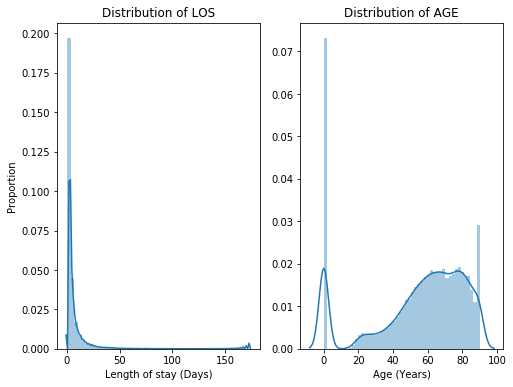

In [8]:
plt.figure(figsize=[8,6])

plt.subplot(1, 2, 1)
sns.distplot(st['LOS'])
plt.xlabel('Length of stay (Days)')
plt.ylabel('Proportion')
plt.title('Distribution of LOS')


plt.subplot(1, 2, 2)
sns.distplot(st['AGE'])
plt.xlabel('Age (Years)')
plt.title('Distribution of AGE')

Distribution of Gender and Mortality


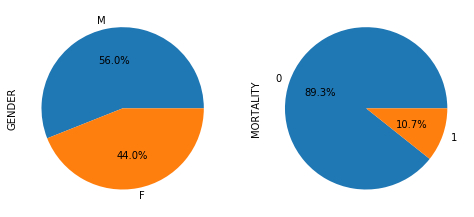

In [9]:
plt.figure(figsize=[8,8])
plt.subplot(1, 2, 1)
st['GENDER'].value_counts().plot.pie(autopct='%1.1f%%')

plt.subplot(1, 2, 2)
st['MORTALITY'].value_counts().plot.pie(autopct='%1.1f%%')

print('Distribution of Gender and Mortality')
plt.show()

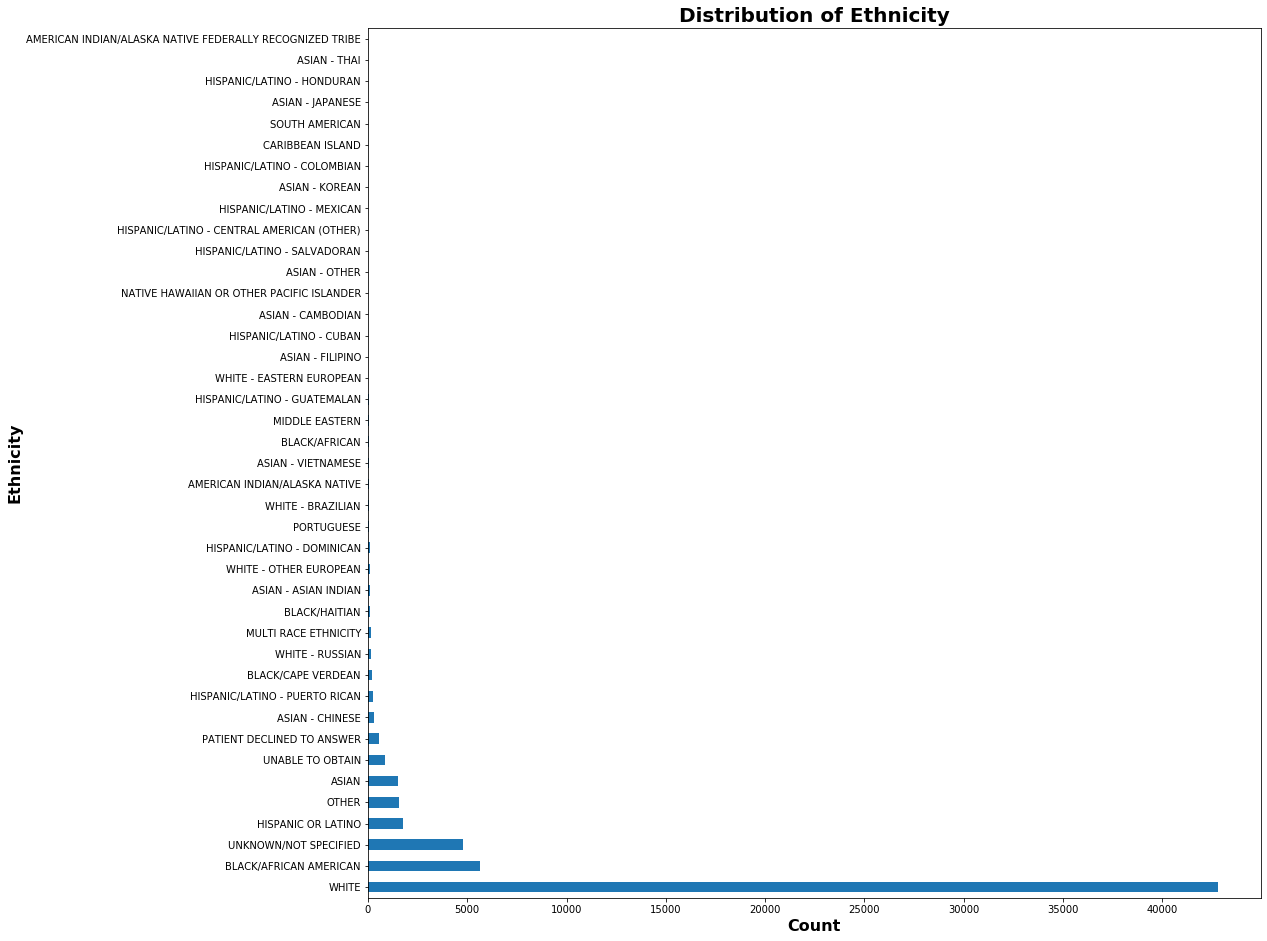

In [10]:
plt.figure(figsize=[16,16])
st['ETHNICITY'].value_counts().plot.barh()
plt.xlabel('Count',fontsize=16, weight='black')
plt.ylabel('Ethnicity',fontsize=16, weight='black')
plt.title('Distribution of Ethnicity',fontsize=20, weight='black')
plt.show()

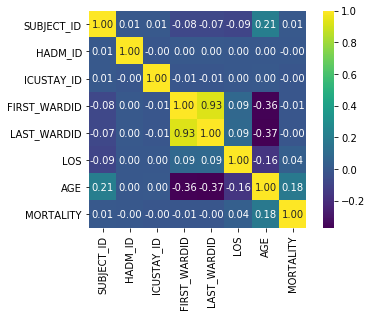

In [11]:
corrmat=st.corr()
sns.heatmap(corrmat, cbar=True, annot=True, square=True,cmap="viridis", fmt='.2f', annot_kws={'size': 10})